<center>
<h1>Welcome to the Lab 🥼🧪</h1>
</center>

## Tracking Invitation Homes Quarterly Activity From the Properties V2 Endpoint

In this notebook, we will analyze Invitation Homes 2024 quarterly activity in the US across in four key metrics
- Acquisitions
- Rental Listings
- Rent Rate
- Inventory

The notebook is broken up into the following sections:
1. Import required packages and setup the Parcl Labs API key and API headers
2. Leverage the V2 Prop Endpoint for the Point in Time Metrics (Aquisitions, Rental Listings and Rent Rate)
3. Leverage both the V1 Prop Endpoint for the Quarterly Inventory

##### Understand changes in supply and Demand YoY
<p align="center">
  <img src="../../../images/INVH_YoY_Changes_tertiary_markets.png" alt="Alt text">
</p>

#### Need help getting started?

**Reminders:**

- You can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along.

- To run this immediately, you can use Google Colab. Remember, you must set your `PARCL_LABS_API_KEY`. 
- To run this notebook at scale and download data for multiple markets and endpoints, you will need to upgrade your Parcl Labs API account from free to starter to get additional credits. You can easily upgrade at any time by visiting your [Parcl Labs dashboard](https://dashboard.parcllabs.com/login), clicking "Upgrade Now" ($99, no commitment). This will unlock more credits immediately.

Run in collab --> [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ParclLabs/parcllabs-cookbook/blob/main/examples/housing_market_research/investor_analytics/invh_yoy_change.ipynb)

### 1. Import required packages and setup the Parcl Labs API key and API headers

In [1]:
# if needed, install and/or upgrade to the latest verison of the Parcl Labs Python library
%pip install --upgrade parcllabs nbformat
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.8 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 249 kB 34.8 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 53.6 MB/s eta 0:00:01
     |████████████████████████████████| 8.9 MB 31.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 22.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import requests
import concurrent.futures
from parcllabs import ParclLabsClient
import matplotlib.pyplot as plt

/Users/zach/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
api_key = os.getenv('PARCL_LABS_API_KEY')
client = ParclLabsClient(api_key, turbo_mode=True)

headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "Authorization": api_key
}

### 2. Leverage the V2 Prop Endpoint for the Point in Time Metrics (Aquisitions, Rental Listings and Rent Rate)

Since all of these metrics will look at data that is grouped quarterly, we can do this most efficiently by pulling all 2024 Activity for IH in one query (~3500 credits) and then analyze the resulting dataframe

In [3]:
## Construct the query for all IH Sale and Rental in 2024 using the National Parcl ID
ih_2024_query = {
    "parcl_ids": [2887280], #Atlanta Market
    "property_filters": {
        "property_types": ["SINGLE_FAMILY"],
        "include_property_details": False #Defaults to True
    },
    "event_filters": {
        "event_names": ["SOLD", "SOLD_INTER_PORTFOLIO_TRANSFER", "RENTAL_PRICE_CHANGE", "LISTED_RENT"],
        "min_event_date": "2024-01-01",
        "max_event_date": "2024-12-31"
    },
    "owner_filters": { "owner_name": ["INVITATION_HOMES"] },
}

In [4]:
## Pass in the query to the API and get the data, this will take ~3500 credits.
## We will use pagination to get all the data and then process it in the next section

try:
    # Initialize container for all events
    all_events = []
    base_url = "https://api.parcllabs.com/v2/property_search"
    limit = 1000
    
    # Function to fetch a page of data
    def fetch_page(offset):
        page_url = f"{base_url}?limit={limit}&offset={offset}"
        resp = requests.post(page_url, json=ih_2024_query, headers=headers)
        data = resp.json()
        
        if "detail" in data:
            raise ValueError(data["detail"])
            
        # Extract events with their property IDs
        events_data = []
        for prop in data.get('data', []):
            property_id = prop.get('parcl_property_id')
            for event in prop.get('events', []):
                events_data.append({"parcl_property_id": property_id, **event})
                
        return events_data, len(data.get('data', []))
    
    # Get first page and metadata
    first_page_events, first_page_props = fetch_page(0)
    all_events.extend(first_page_events)
    
    # Get total properties count for pagination
    meta_resp = requests.post(f"{base_url}?limit=1", json=ih_2024_query, headers=headers).json()
    total = meta_resp.get('metadata', {}).get('results', {}).get('total_available', 0)
    total_pages = (total + limit - 1) // limit  # Ceiling division

    print(f"Found {total} properties, fetched page 1 with {first_page_props} properties and {len(first_page_events)} events")
    print(f"Fetching {total_pages-1} remaining pages in parallel")
    
    if total_pages > 1:
        # Prepare offsets for remaining pages
        offsets = [i * limit for i in range(1, total_pages)]
        
        # Use parallel processing for remaining pages
        with concurrent.futures.ThreadPoolExecutor(max_workers=min(10, len(offsets))) as executor:
            # Submit all page requests
            futures = {executor.submit(fetch_page, offset): offset for offset in offsets}
            
            # Process results as they complete
            for future in concurrent.futures.as_completed(futures):
                offset = futures[future]
                try:
                    page_events, page_props = future.result()
                    all_events.extend(page_events)
                    print(f"Fetched page {offset//limit + 1} with {page_props} properties and {len(page_events)} events")
                except ValueError as e:
                    print(f"Error at offset {offset}: {e}")
                except Exception as e:
                    print(f"Unexpected error at offset {offset}: {e}")
    
    # Create DataFrame
    ih_2024_df = pd.DataFrame(all_events)
    
    # Final verification
    unique_properties = ih_2024_df['parcl_property_id'].nunique()
    print(f"\nFinal results:")
    print(f"Total events collected: {len(ih_2024_df)}")
    print(f"Unique property IDs: {unique_properties}")
    print(f"Expected property count from API: {total}")
    
    # Display sample data
    display(ih_2024_df.head())
    
except ValueError as e:
    print(f"API Error: {e}")
except Exception as e:
    print(f"Error: {e}")

Found 3334 properties, fetched page 1 with 1000 properties and 5874 events
Fetching 3 remaining pages in parallel
Fetched page 4 with 334 properties and 1725 events
Fetched page 2 with 1000 properties and 5815 events
Fetched page 3 with 1000 properties and 6022 events

Final results:
Total events collected: 19436
Unique property IDs: 3334
Expected property count from API: 3334


,parcl_property_id,event_type,event_name,event_date,entity_owner_name,true_sale_index,price,transfer_index,investor_flag,owner_occupied_flag,new_construction_flag,current_owner_flag
0,72308737,RENTAL,LISTED_RENT,2024-07-09,INVITATION_HOMES,2,2220.0,4,1,0,0,1
1,72308737,RENTAL,PRICE_CHANGE,2024-06-24,INVITATION_HOMES,2,2220.0,4,1,0,0,1
2,72308737,RENTAL,LISTED_RENT,2024-06-15,INVITATION_HOMES,2,2240.0,4,1,0,0,1
3,72308737,RENTAL,PRICE_CHANGE,2024-06-07,INVITATION_HOMES,2,2240.0,4,1,0,0,1
4,72308737,RENTAL,PRICE_CHANGE,2024-05-28,INVITATION_HOMES,2,2290.0,4,1,0,0,1


In [7]:
# Create date and quarter columns
ih_2024_df['event_date'] = pd.to_datetime(ih_2024_df['event_date'])
ih_2024_df['quarter'] = ih_2024_df['event_date'].dt.to_period('Q')

# Calculate all metrics in one go
ih_2024_quarterly_metrics = pd.DataFrame({
    'acquisition_count': ih_2024_df[ih_2024_df['event_type'] == 'SALE'].groupby('quarter')['parcl_property_id'].nunique(),
    'median_rent': ih_2024_df[ih_2024_df['event_type'] == 'RENTAL'].groupby('quarter')['price'].median(),
    'rental_listing_count': ih_2024_df[ih_2024_df['event_type'] == 'RENTAL'].groupby('quarter')['parcl_property_id'].nunique()
}).reset_index()

# Format and display
ih_2024_quarterly_metrics['quarter'] = ih_2024_quarterly_metrics['quarter'].astype(str)
ih_2024_quarterly_metrics = ih_2024_quarterly_metrics.sort_values('quarter')

ih_2024_quarterly_metrics

,quarter,acquisition_count,median_rent,rental_listing_count
0,2024Q1,76,2090.0,996
1,2024Q2,10,2145.0,1255
2,2024Q3,18,2095.0,1264
3,2024Q4,10,2049.0,1113


### 3. Leverage both the V2 and V1 Prop Endpoints for the Quarterly Inventory

Inventory is a more complex pull than just point in time metrics, because we need to know if, at a given point in time whether or not that event was the latest event for the property

In [5]:
#Load list of IH Owned Parcl Prop IDs
csv_path = '/Users/zach/Desktop/Repos/parcllabs-cookbook/examples/housing_market_research/investor_analytics/invitation_homes_property_ids.csv'  # Update this to your CSV path
property_df = pd.read_csv(csv_path)

parcl_property_id_list = property_df['PARCL_PROPERTY_ID'].unique().tolist()

print(f"Loaded {len(parcl_property_id_list)} unique property IDs")

Loaded 102492 unique property IDs


In [9]:
#Pass list of IH Owned Parcl Prop IDs to the V1 Endpoint
ih_owned_events = client.property.events.retrieve(
        parcl_property_ids=parcl_property_id_list,
        end_date='2024-12-31',
        event_type='SALE',

)

In [10]:
ih_owned_events

,parcl_property_id,event_date,event_type,event_name,price,owner_occupied_flag,new_construction_flag,investor_flag,entity_owner_name,current_owner_flag,transfer_index,true_sale_index,record_updated_date
0,48714880,2018-07-10,SALE,NON_ARMS_LENGTH_INTRA_PORTFOLIO_TRANSFER,0.0,0.0,0,1.0,INVITATION_HOMES,1,6,2,2024-12-13
1,48714880,2017-11-16,SALE,NON_ARMS_LENGTH_INTRA_PORTFOLIO_TRANSFER,0.0,0.0,0,1.0,INVITATION_HOMES,0,5,2,2024-12-13
2,48714880,2012-11-16,SALE,SOLD,298000.0,0.0,0,1.0,INVITATION_HOMES,0,4,2,2024-12-13
3,48714880,2010-12-27,SALE,NON_ARMS_LENGTH_TRANSFER,0.0,1.0,0,1.0,None,0,3,1,2024-12-13
4,48762102,2018-11-14,SALE,NON_ARMS_LENGTH_INTRA_PORTFOLIO_TRANSFER,0.0,0.0,0,1.0,INVITATION_HOMES,1,11,2,2024-12-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338716,435215176,2024-05-06,SALE,SOLD_INTER_PORTFOLIO_TRANSFER,2277400.0,0.0,0,1.0,INVITATION_HOMES,1,2,1,2024-12-13
338717,435215176,2022-07-26,SALE,NON_ARMS_LENGTH_TRANSFER,0.0,0.0,1,1.0,None,0,1,0,2024-12-13
338718,451511449,2024-09-19,SALE,SOLD,19600000.0,0.0,1,1.0,INVITATION_HOMES,1,2,1,2024-12-13
338719,451511449,2023-06-28,SALE,NON_ARMS_LENGTH_TRANSFER,0.0,0.0,1,NaN,None,0,1,0,2024-12-13


In [15]:
# First, ensure dates are in datetime format
ih_owned_events['event_date'] = pd.to_datetime(ih_owned_events['event_date'])

# Generate list of quarter end dates
start_date = pd.Timestamp('2019-01-01')
end_date = pd.Timestamp('2024-12-31')
quarter_ends = pd.date_range(start=start_date, end=end_date, freq='QE')

# Initialize results dictionary
quarterly_inventory = {}

# Process each quarter end date
for quarter_end in quarter_ends:
    # Filter events up to this quarter end
    events_until_quarter = ih_owned_events[ih_owned_events['event_date'] < quarter_end]
    
    # Group by property ID and get the most recent event for each property
    latest_events = events_until_quarter.sort_values(
        by=['parcl_property_id', 'event_date'], ascending=[True, False]
    )

    latest_event_dedupe = latest_events.drop_duplicates(
        subset=['parcl_property_id'], keep='first'
    )
    
    # Count properties where INVITATION_HOMES is the owner
    owned_count = len(latest_event_dedupe[latest_event_dedupe['entity_owner_name'] == 'INVITATION_HOMES'])
    
    # Store the count for this quarter with correct formatting
    year = quarter_end.year
    quarter_num = (quarter_end.month - 1) // 3 + 1
    quarter_key = f"{year}Q{quarter_num}"
    quarterly_inventory[quarter_key] = owned_count

# Convert to DataFrame for easier viewing
inventory_df = pd.DataFrame(list(quarterly_inventory.items()), columns=['quarter_end', 'invitation_homes_inventory'])

# Sort chronologically
inventory_df = inventory_df.sort_values('quarter_end')

Invitation Homes quarterly inventory from Q1 2019 through Q4 2024:


,quarter_end,invitation_homes_inventory
0,2019Q1,78116
1,2019Q2,78447
2,2019Q3,78448
3,2019Q4,77963
4,2020Q1,78041
5,2020Q2,77796
6,2020Q3,77899
7,2020Q4,78679
8,2021Q1,79127
9,2021Q2,79787


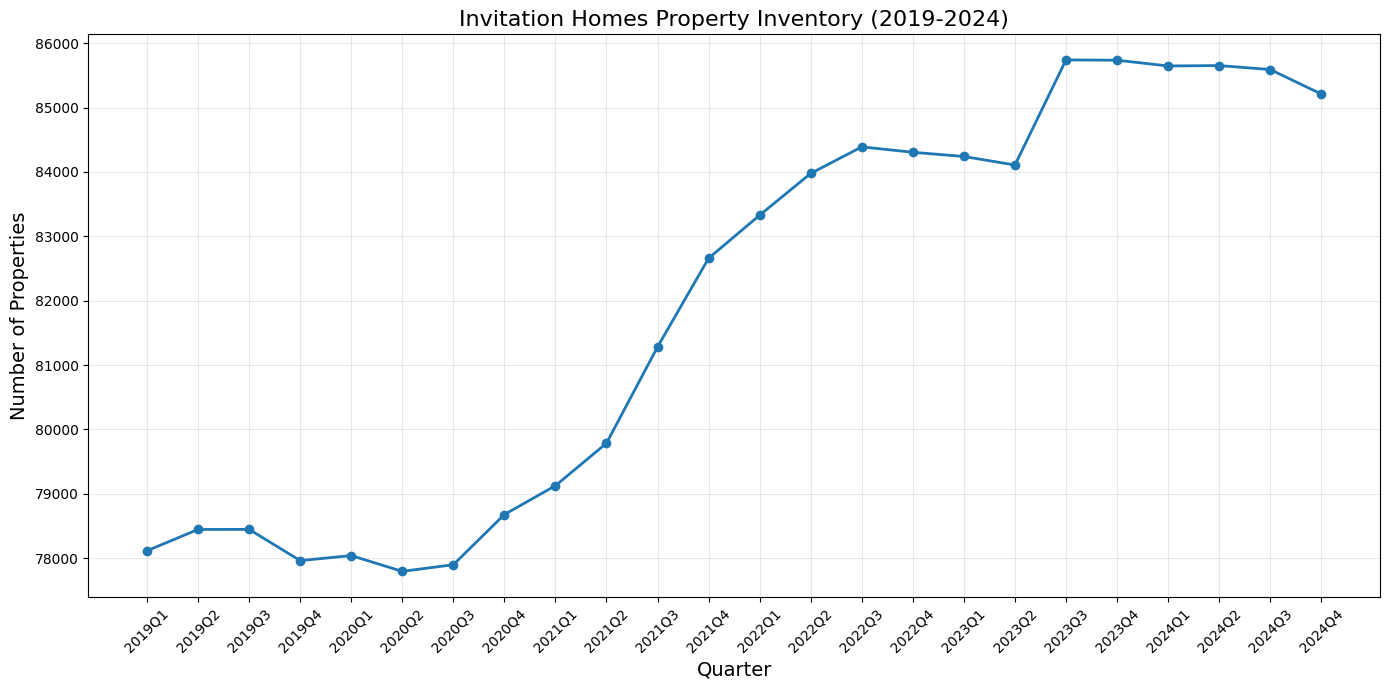

In [16]:
# Display results
print(f"Invitation Homes quarterly inventory from Q1 2019 through Q4 2024:")
display(inventory_df)

plt.figure(figsize=(14, 7))
plt.plot(inventory_df['quarter_end'], inventory_df['invitation_homes_inventory'], marker='o', linewidth=2)
plt.title('Invitation Homes Property Inventory (2019-2024)', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Number of Properties', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()